In [23]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import ta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as lyrs
from tensorflow.python.keras import backend as k

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from tensorflow.keras.models import Sequential, load_model

import math, time #helper libraries
import datetime

import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt

# Helper functions

In [39]:
## adapted from: 
## https://github.com/etai83/lstm_stock_prediction/blob/master/.ipynb_checkpoints/GOOGLE%20stock%20prediction-checkpoint.ipynb

def split_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [40]:
def build_model(layers):
        d = 0.2
        model = tf.keras.Sequential()
        model.add(lyrs.LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(lyrs.Dropout(d))
        model.add(lyrs.LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(lyrs.Dropout(d))
        model.add(lyrs.Dense(16,activation='tanh')) #kernel_initializer='uniform'        
        model.add(lyrs.Dense(1,activation='tanh')) #kernel_initializer='uniform'
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

# Data manipulation and Learning

In [98]:
data = yf.download('GOOGL','2015-06-15','2019-06-16') # 'GOOGL','2013-07-12','2017-07-11'

data = data.reset_index()
data=data.drop(['Date'], axis = 1)
data.drop(data.columns[[2,4,5]], axis=1, inplace=True) 
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Close
0,542.729980,544.049988,543.000000
1,544.479980,546.690002,544.869995
2,545.419983,548.359985,546.599976
3,548.000000,557.250000,556.179993
4,556.520020,557.909973,557.520020


## Norming/Scaling

In [99]:
#just dividing by highest price
def num_scaler(data):
    data['High'] = data['High'] / 1000
    data['Open'] = data['Open'] / 1000
    data['Close'] = data['Close'] / 1000
    return data

def min_max_scaler(data):
    scaler = preprocessing.MinMaxScaler()
    data['High'] = scaler.fit_transform(data.High.values.reshape(-1,1))
    data['Open'] = scaler.fit_transform(data.Open.values.reshape(-1,1))
    data['Close'] = scaler.fit_transform(data.Close.values.reshape(-1,1))
    return data
    
def robust_scaler(data):
    scaler = preprocessing.RobustScaler()
    data['High'] = scaler.fit_transform(data.High.values.reshape(-1,1))
    data['Open'] = scaler.fit_transform(data.Open.values.reshape(-1,1))
    data['Close'] = scaler.fit_transform(data.Close.values.reshape(-1,1))
    return data

In [100]:
data = robust_scaler(data)
data.head()

,Open,High,Close
0,-1.255079,-1.236407,-1.244265
1,-1.249592,-1.228337,-1.238435
2,-1.246646,-1.223232,-1.233042
3,-1.238557,-1.196057,-1.203174
4,-1.211847,-1.194040,-1.198996


In [101]:
window = 5
X_train, y_train, X_test, y_test = split_data(data, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (902, 5, 3)
y_train (902,)
X_test (100, 5, 3)
y_test (100,)


/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [114]:
model = make_model([3,window,1])
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.30 MSE (0.55 RMSE)
Test Score: 0.46 MSE (0.68 RMSE)


In [117]:
diff=[]
ratio=[]
p = model.predict(X_test) *30 + .29
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

## Plotting

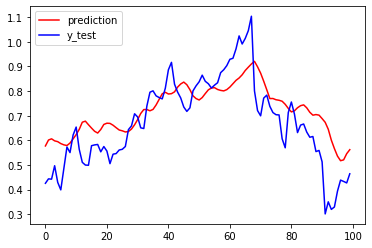

In [118]:
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()